### Importing Libraries and Dependencies

This cell organises all necessary libraries for the object detection pipeline:

- **Standard Library**:  
  `os` and `shutil` are used for interacting with the file system, managing files and directories.

- **Third-Party Libraries**:  
  - `NumPy` is used for numerical operations.  
  - `Matplotlib` (`pyplot`, `patches`, and `image`) helps with visualising images and drawing bounding boxes.  
  - `PIL.Image` is used for image processing.

- **TensorFlow and Keras**:  
  Used to construct and train deep learning models. The `InceptionV3` model from `keras.applications` is used as a pre-trained feature extractor.

- **Ultralytics YOLO**:  
  Imports the latest YOLO models (e.g., YOLOv8 or YOLOv10) from the Ultralytics library for optional use in the detection pipeline.


In [2]:
# === Standard Library ===
import os
import shutil  # For high-level file operations (e.g., move, copy, delete)

# === Third-Party Libraries ===
import numpy as np  # Numerical operations and array manipulation
import matplotlib.pyplot as plt  # Plotting and visualisation
import matplotlib.patches as patches  # Drawing bounding boxes
from matplotlib.patches import Rectangle  # Alias for drawing rectangles
import matplotlib.image as mpimg  # For reading and displaying images
from PIL import Image  # Pillow library for image processing

# === TensorFlow and Keras ===
import tensorflow as tf
from tensorflow.keras import layers, models  # Building neural networks
from tensorflow.keras.applications import InceptionV3  # Pre-trained backbone
from tensorflow.keras.optimizers.schedules import ExponentialDecay #learning rate decay
from tensorflow.keras.optimizers import AdamW #optimizer

# === Ultralytics (YOLO) ===
from ultralytics import YOLO  # YOLOv8 and v10 model integration

### Visualising YOLO Annotations on a Sample Image

This cell demonstrates how to visualise bounding boxes from YOLO-format label files:

- It selects a `.jpg` image from the test dataset directory and locates its corresponding `.txt` label file.
- Each label line contains a class ID and bounding box coordinates in normalised YOLO format:  
  `[class_id, x_center, y_center, width, height]`, all relative to image size.
- These coordinates are converted to absolute pixel values to draw the box using `matplotlib.patches.Rectangle`.
- The box is annotated with the object class and dimensions for easier debugging and analysis.
- Finally, the annotated image is displayed with a title and without axis ticks.

This visualisation is useful for checking whether label files are correctly aligned with the image content before model training.


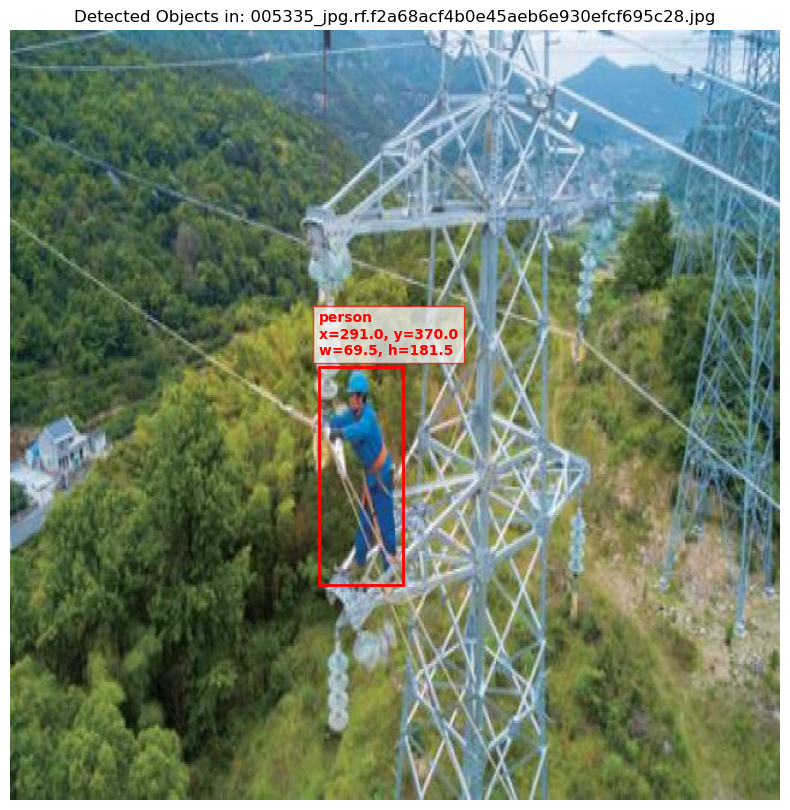

In [4]:
# === Dataset Path ===
dataset_dir = "C:/Users/Aidyn/Downloads/People Detection -General-.v8i.darknet/test"

# === Map Class IDs to Names ===
class_names = {
    0: "person"  # Extend this if there are more classes
}

# === Load One Sample Image and Its Label ===
image_files = [f for f in os.listdir(dataset_dir) if f.endswith(".jpg")]
sample_image = image_files[1]  # Select the second image
image_path = os.path.join(dataset_dir, sample_image)
label_path = os.path.splitext(image_path)[0] + ".txt"

# === Load the Image ===
img = Image.open(image_path).convert("RGB")
img_width, img_height = img.size

# === Set Up the Plot ===
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img)

# === Read and Draw Bounding Boxes from Label File ===
with open(label_path, "r") as f:
    for line in f.readlines():
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center_norm, y_center_norm, w_norm, h_norm = map(float, parts[1:])

        # Convert YOLO Normalised Coords to Absolute Pixel Values
        x_center = x_center_norm * img_width
        y_center = y_center_norm * img_height
        w = w_norm * img_width
        h = h_norm * img_height

        # Calculate Top-Left Corner of the Bounding Box
        x0 = x_center - w / 2
        y0 = y_center - h / 2

        # Draw the Bounding Box
        rect = patches.Rectangle((x0, y0), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # Add Label Text
        class_name = class_names.get(class_id, f"class_{class_id}")
        label_text = (
            f"{class_name}\n"
            f"x={x_center:.1f}, y={y_center:.1f}\n"
            f"w={w:.1f}, h={h:.1f}"
        )
        ax.text(x0, y0 - 10, label_text, color='red', fontsize=10, weight='bold',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='red'))

# === Final Display ===
plt.title(f"Detected Objects in: {sample_image}")
plt.axis('off')
plt.show()


### Encoding YOLO Labels into a Tensor Format

This function converts a list of YOLO-format bounding box annotations into a training-ready tensor of shape `(grid_size, grid_size, anchor_size, depth_size)`.

- **Input format**: Each label is `[class_id, x_center, y_center, width, height]`, all normalised to the range [0, 1].
- **Grid mapping**: The object’s centre is mapped to a specific cell in the grid (e.g., 19×19), and its coordinates are converted to offsets within that cell.
- **Anchor assignment**:
  - Anchor 0 is used for roughly square objects (aspect ratio between 0.8 and 1.2).
  - Anchor 1 is a fallback for remaining boxes.
- **Output tensor**:
  - Each anchor in a grid cell holds `[x_offset, y_offset, w_cell, h_cell, objectness]`.
  - The tensor is filled only if the corresponding anchor is available.

This structure prepares the label information for use in a YOLO-style loss function during training.


---
### Simplifying Class and Objectness for Single-Class Detection

In standard object detection models like YOLO, each anchor box typically outputs:


- `PC` (objectness score): Indicates whether an object exists in the grid cell.
- `CLS_1 ... CLS_n`: Probabilities for each class (when `n` is the number of classes).
- This results in a total of `5 + num_classes` output values per anchor.

####  Our Simplification for Single-Class Detection

Since we are only detecting **one class** (`person`), we simplify the output to:


- The `obj` score here **combines both**:
  - The objectness confidence (is there an object?)
  - The class confidence (if there is an object, it's definitely a person)

This approach reduces:
- The output dimensionality (from 6 to 5 per anchor)
- Computational complexity
- The burden on the model to learn redundant class probabilities

It’s a practical design when:
- You have large datasets
- You’re working with just one class
- Training time and memory efficiency are important


---
### Manual Anchor Assignment Based on Aspect Ratio

In our dataset, the YOLO-format annotations do not specify which anchor box should be responsible for detecting each object. To address this, we apply a heuristic:

- **Anchor 0** is assigned to objects that are roughly **square-shaped** (aspect ratio between 0.8 and 1.2).
- **Anchor 1** serves as a **fallback** for remaining cases, typically more rectangular objects or when Anchor 0 is already occupied.

This simple yet effective strategy avoids conflicts between anchors and allows the model to learn anchor-specific predictions more efficiently without needing predefined anchor box dimensions.


In [8]:
def yolo_label_tensor(labels, grid_size=19, anchor_size=2, depth_size=5):
    """
    Converts YOLO-format bounding box labels into a tensor suitable for training.

    Parameters:
    - labels: List of YOLO-format labels, each as [class_id, x, y, w, h] (all values normalized 0–1)
    - grid_size: Number of grid cells along width/height (e.g., 19 for 19x19)
    - anchor_size: Number of anchor boxes per grid cell (e.g., 2)
    - depth_size: Number of output values per anchor box (default 5: [x, y, w, h, obj])

    Returns:
    - target: A NumPy array of shape (grid_size, grid_size, anchor_size, depth_size)
              Each cell/anchor stores [x_offset, y_offset, w_cell, h_cell, objectness]
    """

    # Initialize the target tensor with zeros
    target = np.zeros((grid_size, grid_size, anchor_size, depth_size), dtype=np.float32)

    for label in labels:
        # Extract individual values from label
        cls, x, y, w, h = label  # Note: 'cls' is ignored because this is for one-class detection

        # Calculate absolute cell position in the grid (float)
        cell_x = x * grid_size
        cell_y = y * grid_size

        # Convert to integer grid indices (grid column and row)
        grid_x = int(cell_x)
        grid_y = int(cell_y)

        # Compute offset of object centre within the grid cell (relative position inside cell)
        x_offset = cell_x - grid_x
        y_offset = cell_y - grid_y

        # Scale width and height from image-level normalised size to grid-level size
        w_cell = w * grid_size
        h_cell = h * grid_size

        # Compute the aspect ratio to distinguish square vs. rectangular shapes
        aspect_ratio = h_cell / (w_cell + 1e-6)  # Add small value to avoid division by zero

        # === Box Assignment Logic ===
        # Prefer box 0 for roughly square objects (aspect ratio ~1:1)
        if target[grid_y, grid_x, 0, 4] == 0 and 0.8 <= aspect_ratio <= 1.2:
            target[grid_y, grid_x, 0] = [x_offset, y_offset, w_cell, h_cell, 1.0]

        # Otherwise, assign to box 1 if it's still unused
        elif target[grid_y, grid_x, 1, 4] == 0:
            target[grid_y, grid_x, 1] = [x_offset, y_offset, w_cell, h_cell, 1.0]

        # If both anchors are occupied, the label is skipped (optional: handle overlaps)

    return target


### Custom Keras Data Generator for YOLO Training

This class defines a custom `tf.keras.utils.Sequence` dataset generator that feeds YOLO-compatible data into a TensorFlow/Keras training loop:

- **Image loading and preprocessing**:
  - Images are read from disk, resized to a fixed square shape (e.g., 640×640), and normalised to the `[0, 1]` range.
  
- **Label processing**:
  - Each image is expected to have a `.txt` label file in YOLO format:  
    `[class_id, x_center, y_center, width, height]` with values normalised to the image dimensions.
  - The labels are converted to tensors using the `yolo_label_tensor()` function. These tensors have shape `(grid_size, grid_size, anchor_size, depth_size)`.

- **Output structure**:
  - The generator yields batches of images and labels, suitable for direct input into a YOLO-style model and loss function.

This setup supports efficient training with Keras’ `fit()` API and ensures proper shuffling, batching, and pre-processing of both images and annotations.


In [10]:
class YoloDataset(tf.keras.utils.Sequence):
    """
    Custom Keras-compatible data loader for YOLO-style object detection.

    Loads images and their corresponding YOLO-format labels,
    converts them into training-ready batches.

    Each label is encoded into a (grid_size, grid_size, anchor_size, depth_size) tensor.
    """

    def __init__(self, folder, image_size=640, batch_size=8,
                 grid_size=19, anchor_size=2, depth_size=5,shuffle=True, **kwargs):
        """
        Initialise the dataset.

        Parameters:
        - folder: Path to the dataset directory containing images and label files
        - image_size: Size to which all images are resized (image_size x image_size)
        - batch_size: Number of samples per batch
        - grid_size: Number of grid cells per axis (e.g. 19 → 19x19 grid)
        - anchor_size: Number of anchor boxes per grid cell
        - depth_size: Number of outputs per anchor box (e.g. 5 → [x, y, w, h, obj])
        """
        super().__init__(**kwargs)
        self.grid_size = grid_size
        self.anchor_size = anchor_size
        self.depth_size = depth_size
        self.folder = folder
        self.image_size = image_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.images = [f for f in os.listdir(folder) if f.endswith(".jpg")]
        self.on_epoch_end()  # Shuffle initially

    def __len__(self):
        """
        Return the total number of batches per epoch.
        """
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        """
        Generate one batch of data.

        Parameters:
        - idx: Batch index

        Returns:
        - x_batch: Batch of images, shape (batch_size, image_size, image_size, 3)
        - y_batch: Batch of label tensors, shape (batch_size, grid_size, grid_size, anchor_size, depth_size)
        """
        batch_imgs = self.images[idx * self.batch_size : (idx + 1) * self.batch_size]
        x_batch, y_batch = [], []

        for img_name in batch_imgs:
            img_path = os.path.join(self.folder, img_name)
            label_path = os.path.splitext(img_path)[0] + ".txt"

            # === Load and preprocess image ===
            img = Image.open(img_path).convert("RGB").resize((self.image_size, self.image_size))
            img = (np.array(img, dtype=np.float32) / 127.5) - 1.0  # Normalize to [-1, 1] for Inception
            x_batch.append(img)
            
            # === Load and process YOLO-format labels ===
            labels = []
            if os.path.exists(label_path):
                with open(label_path, "r") as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) == 5:
                            labels.append(list(map(float, parts)))  # [class, x, y, w, h]

            # === Convert labels to YOLO tensor ===
            y_tensor = yolo_label_tensor(
                labels,
                grid_size=self.grid_size,
                anchor_size=self.anchor_size,
                depth_size=self.depth_size
            )
            y_batch.append(y_tensor)

        return np.array(x_batch), np.array(y_batch)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.images)


### Custom YOLO Loss Function (with IoU and False Positive Penalty)

This function defines a custom YOLO-style loss designed for single-class object detection. It consists of the following components:

- **Box Regression Loss**:  
  Uses IoU between predicted and true boxes, penalising low-overlap predictions with:

box_loss = (1 - IoU)²

Only active when an object is present (`obj_mask`).

- **Objectness Loss (Binary Cross-Entropy)**:  
Applied to both object and no-object regions using binary cross-entropy:
- Weighted more for true object positions (`lambda_obj`)
- Still penalised for false positives (`lambda_noobj`)

- **False Positive Control**:  
Adds an extra penalty term:

if predicted confidence > threshold and no object is present → penalise

Helps suppress spurious predictions in empty regions.

- **Final Loss**:  
The total loss is normalised by the number of true objects to stabilise training across batches of varying density.

This design balances localization accuracy, objectness confidence, and false-positive suppression well suited for dense datasets or single-class models.


In [12]:
def custom_yolo_loss(threshold=0.5):
    def loss_fn(y_true, y_pred):
        # Split inputs into box coordinates and objectness
        true_box = y_true[..., 0:4]
        true_obj = y_true[..., 4:5]
        pred_box = y_pred[..., 0:4]
        pred_obj = y_pred[..., 4:5]

        # Create masks for object and no-object positions
        obj_mask = tf.cast(true_obj > 0, tf.float32)
        noobj_mask = 1.0 - obj_mask

        # === IoU Calculation ===
        def bbox_iou(box1, box2):
            # Convert center x, y, w, h to x1, y1, x2, y2
            b1_x1 = box1[..., 0] - box1[..., 2] / 2
            b1_y1 = box1[..., 1] - box1[..., 3] / 2
            b1_x2 = box1[..., 0] + box1[..., 2] / 2
            b1_y2 = box1[..., 1] + box1[..., 3] / 2

            b2_x1 = box2[..., 0] - box2[..., 2] / 2
            b2_y1 = box2[..., 1] - box2[..., 3] / 2
            b2_x2 = box2[..., 0] + box2[..., 2] / 2
            b2_y2 = box2[..., 1] + box2[..., 3] / 2

            # Intersection coordinates
            inter_x1 = tf.maximum(b1_x1, b2_x1)
            inter_y1 = tf.maximum(b1_y1, b2_y1)
            inter_x2 = tf.minimum(b1_x2, b2_x2)
            inter_y2 = tf.minimum(b1_y2, b2_y2)

            inter_area = tf.maximum(inter_x2 - inter_x1, 0) * tf.maximum(inter_y2 - inter_y1, 0)
            box1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
            box2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)
            union_area = box1_area + box2_area - inter_area

            return inter_area / (union_area + 1e-6)

        # === Box Loss: penalise poor IoU where there is an object ===
        iou = bbox_iou(true_box, pred_box)
        box_loss = obj_mask * tf.square(1.0 - iou)[..., None]

        # === Objectness Loss (Binary Cross Entropy) ===
        bce = tf.keras.losses.binary_crossentropy
        bce_loss = bce(true_obj, pred_obj)[..., None]

        # === False Positive Penalty ===
        lambda_obj = 2.0
        lambda_noobj = 1.0
        lambda_fp = 1.5

        false_positive_mask = tf.cast((pred_obj > threshold) & (true_obj < 1e-3), tf.float32)

        obj_loss = (
            lambda_obj * obj_mask * bce_loss +
            lambda_noobj * noobj_mask * bce_loss +
            lambda_fp * false_positive_mask * pred_obj**2
        )

        # === Final Loss (Normalised) ===
        num_true_objs = tf.reduce_sum(obj_mask) + 1e-6
        total_loss = tf.reduce_sum(box_loss + obj_loss) / num_true_objs

        return total_loss

    return loss_fn


### Fine-Tuned YOLO-Inception Model with Layer-Specific Training

This function defines a custom object detection model that combines a pretrained **InceptionV3** backbone with a YOLO-style detection head, and includes selective fine-tuning and learning rate scheduling.

---

#### Key Highlights:

- **Backbone: InceptionV3**
  - Pretrained on ImageNet (`include_top=False`)
  - All layers **frozen**, except for the `mixed7` layer, which serves as the **feature extraction point**.
  - This allows for **targeted fine-tuning** — adapting only the feature map source to the custom dataset, improving flexibility without overfitting.

- **Detection Head**:
  - A `Conv2D` layer outputs `anchors × depth` predictions per grid cell.
  - Outputs are reshaped to `(grid_size, grid_size, anchors, depth)` for YOLO loss compatibility.

- **Learning Rate Scheduler**:
  - Uses `ExponentialDecay` to gradually reduce learning rate every 100 steps.
  - Helps the model converge smoothly, especially useful when combining frozen and trainable layers.

- **Custom YOLO Loss**:
  - Incorporates IoU loss, objectness confidence, and false-positive penalties based on thresholded predictions.

---

> This hybrid architecture balances the power of transfer learning with custom model control — ideal for training object detectors on modest datasets with fewer resources.


In [14]:
def build_inception_yolo_model(image_shape=(640, 640, 3), grid_size=19, anchors=2, depth=5, threshold=0.5):
    # === Load InceptionV3 Backbone ===
    base_model = InceptionV3(include_top=False, input_shape=image_shape, weights="imagenet")

    # === Freeze all layers except 'mixed7' and 'mixed6' for targeted fine-tuning ===
    for layer in base_model.layers:
        layer.trainable = ("mixed7" in layer.name) or ("mixed6" in layer.name)

    # === Extract Feature Map from 'mixed7' ===
    x = base_model.get_layer("mixed7").output  # Shape: (19, 19, 768)

    # === Resize feature map to match the YOLO grid size ===
    x = layers.Resizing(grid_size, grid_size)(x)

    # === Conv + ReLU before dropout (helps learning) ===
    x = layers.Conv2D(512, kernel_size=3, padding="same", activation="relu")(x)

    # === Add Dropout layer (high dropout for regularisation) ===
    x = layers.Dropout(0.75)(x)

    # === YOLO-style Prediction Head ===
    x = layers.Conv2D(anchors * depth, kernel_size=1, padding="same", activation="sigmoid")(x)
    output = layers.Reshape((grid_size, grid_size, anchors, depth))(x)

    # === Create the Complete Model ===
    model = models.Model(inputs=base_model.input, outputs=output)

    # === Learning Rate Scheduler ===
    lr_schedule = ExponentialDecay(
        initial_learning_rate=1e-4,  # Start with low LR for stable training
        decay_steps=100,             # Every 100 steps, apply decay
        decay_rate=0.95,             # Reduce LR by 5%
        staircase=True               # Apply decay in steps (not continuously)
    )

    optimizer = AdamW(learning_rate=lr_schedule, weight_decay=1e-4)

    # === Compile the Model with Custom YOLO Loss ===
    model.compile(optimizer=optimizer, loss=custom_yolo_loss(threshold=threshold))

    return model

### Training and Evaluation Pipeline

This section loads the training and testing datasets, builds the model, and performs a single training epoch followed by evaluation.

- **Train/Test Paths**:  
  Two directories (`train/`, `test/`) contain YOLO-format `.jpg` images and `.txt` label files.

- **Dataset Loading**:  
  `YoloDataset` wraps the data into Keras-compatible generators, automatically preprocessing the images and encoding labels into tensors suitable for the custom YOLO loss.

- **Model Training**:  
  The model is trained using the custom `InceptionV3`-YOLO architecture. The training loop uses Keras' high-level `fit()` API.  
  Only **one epoch** is used here to avoid excessive computation during prototyping, especially given the large model size and dataset volume.

- **Evaluation**:  
  The model is evaluated on the test set using `model.evaluate()`. The output is the total loss averaged over all test samples.

---

### Note on Infrastructure Constraints

This experiment is **CPU-oriented** and executed in an environment without dedicated GPU acceleration. Since:

- The model uses a large InceptionV3 backbone (millions of parameters),
- The training dataset is extensive,
- TensorFlow `Sequence` and multi-threading on CPU are not optimised for parallel execution in this setup,

the training can be extremely slow without GPU support.

To mitigate this:

- **Only one epoch** is used enough to verify pipeline correctness and get a baseline loss.
- On **Google Cloud**, the same setup is tested with GPU acceleration for better performance.
- When using **YOLOv8x via Ultralytics**, the training is much faster and more effective. This custom model is not expected to outperform YOLOv8x but provides insight into the architecture design and loss function implementation.

This setup reflects the importance of **infrastructure** in deep learning workflows; more epochs or larger models require robust hardware, particularly for object detection tasks.


In [16]:
# === Paths ===
train_dir = "C:/Users/Aidyn/Downloads/People Detection -General-.v8i.darknet/train"
test_dir = "C:/Users/Aidyn/Downloads/People Detection -General-.v8i.darknet/test"

# === Load YOLO-Formatted Data ===
train_data = YoloDataset(train_dir)
test_data = YoloDataset(test_dir)

# === Build the YOLO-InceptionV3 Model ===
model = build_inception_yolo_model()

# === Train the Model ===
# Note: Use more epochs for real training
model.fit(train_data, epochs=2)

# === Evaluate on Test Data ===
test_loss = model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")


Epoch 1/2
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 3011s 1s/step - loss: 21.5345
Epoch 2/2
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 3386s 2s/step - loss: 8.1376
238/238 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - loss: 8.3498
Test Loss: 8.4711


### Model Evaluation Results (InceptionV3-YOLO)

After training the custom object detection model using InceptionV3 as a backbone with our YOLO-style prediction head, we evaluated its performance on both the training and test datasets:

- **Training Loss**: `7.5770`
- **Test Loss**: `8.4711`

These values indicate that the model generalises reasonably well with no significant overfitting. However, the slightly higher test loss suggests some room for improvement in terms of generalisation or bounding box precision, especially under varied lighting or crowd scenarios.


In [34]:
# === Evaluate on Train Data ===
train_loss = model.evaluate(train_data)
print(f"Teain Loss: {train_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")

2025/2025 ━━━━━━━━━━━━━━━━━━━━ 3169s 2s/step - loss: 7.5863
Teain Loss: 7.5770
Test Loss: 8.4711


In [42]:
model.save(r"D:\test\inception_yolo_model.keras")

### Load and Preprocess a Test Image for InceptionV3

This cell loads and prepares a single test image for inference using the InceptionV3-based model:

- The image is selected from the test directory by index.
- It is resized to `640×640` pixels to match the input shape of the model.
- Pixel values are **rescaled from [0, 255] to [-1, 1]**, which is the expected input range for **InceptionV3**.
- A batch dimension is added to convert the shape to `(1, 640, 640, 3)` — required for model prediction.

This normalisation ensures that the input aligns with the pretrained InceptionV3 backbone and improves inference consistency.


In [48]:
# === Load a Test Image from the Test Directory ===
test_img_name = [f for f in os.listdir(test_dir) if f.endswith(".jpg")][1]
test_img_path = os.path.join(test_dir, test_img_name)

# === Open and Preprocess Image ===
img = Image.open(test_img_path).convert("RGB").resize((640, 640))

# Normalize image to [-1, 1], as expected by InceptionV3
img_np = (np.array(img) / 127.5) - 1.0

# Add batch dimension → shape: (1, 640, 640, 3)
img_input = np.expand_dims(img_np, axis=0)

### Post-Processing and Visualisation of YOLO Predictions

This section processes the raw model output, filters valid predictions, applies Non-Maximum Suppression (NMS), and visualises final bounding boxes:

---

#### Step 1: Extract Valid Boxes

- Each grid cell and anchor combination produces 5 values: `[x, y, w, h, obj]`.
- If the objectness score (`obj`) is above `OBJ_THRESHOLD`, the box is kept.
- Box coordinates are converted from YOLO-relative grid format to absolute pixel format using:
  - cx = (grid_col + x) * cell_size
  - cy = (grid_row + y) * cell_size


---

####  Step 2: Non-Maximum Suppression (NMS)

- Multiple boxes may overlap and predict the same object.
- NMS retains the highest-scoring box and removes others with **IoU > 0.55**.
- IoU is computed between all box pairs to eliminate redundant detections.

---

####  Step 3: Visualisation

- Final bounding boxes are drawn using `matplotlib.patches.Rectangle`.
- Only boxes that survived thresholding and NMS are shown.
- Labels display the objectness score (confidence).

---

This post-processing replicates the logic used in YOLO pipelines to produce final predictions ready for visual inspection or downstream evaluation.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
0.44900665 0.49353358 0.9732892 0.982984 0.3310718
284.5981186314633 353.4663943240517 32.78447803698088 33.111040215743216 0.3310718


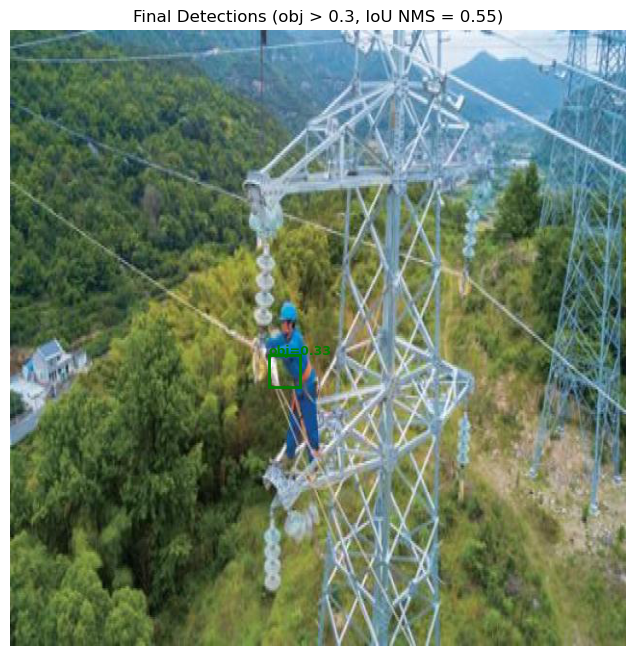

In [57]:
# === Constants ===
GRID_SIZE = 19
IMG_SIZE = 640
CELL_SIZE = IMG_SIZE / GRID_SIZE
OBJ_THRESHOLD = 0.3     # Minimum objectness score to keep a box
IOU_THRESHOLD = 0.55    # IoU threshold for NMS

# === Run Model Prediction ===
pred = model.predict(img_input)[0]  # shape: (19, 19, 2, 5)

boxes = []
scores = []

# === Step 1: Extract and Convert Valid Boxes ===
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        for k in range(2):
            x, y, w, h, obj = pred[i, j, k]

            if obj <= OBJ_THRESHOLD:
                continue

            # Convert (x, y, w, h) from grid to pixel coordinates
            cx = (j + x) * CELL_SIZE
            cy = (i + y) * CELL_SIZE
            ww = w * CELL_SIZE
            hh = h * CELL_SIZE

            if ww < 1 or hh < 1:
                continue  # Skip very small boxes

            x0 = cx - ww / 2
            y0 = cy - hh / 2
            x1 = cx + ww / 2
            y1 = cy + hh / 2

            boxes.append([x0, y0, x1, y1])
            scores.append(obj)
            print(x,y,w,h,obj)
            print(cx,cy,ww,hh,obj)

boxes = np.array(boxes)
scores = np.array(scores)

# === Step 2: Non-Maximum Suppression (NMS) ===
def compute_iou(box1, box2):
    """Compute Intersection over Union (IoU) between two boxes."""
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    inter_area = max(0, xB - xA) * max(0, yB - yA)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - inter_area

    return inter_area / union if union > 0 else 0

def non_max_suppression(boxes, scores, iou_thresh):
    """Return indices of boxes to keep after NMS."""
    indices = np.argsort(scores)[::-1]
    keep = []

    while len(indices) > 0:
        current = indices[0]
        keep.append(current)
        rest = indices[1:]

        indices = [
            i for i in rest
            if compute_iou(boxes[current], boxes[i]) <= iou_thresh
        ]

    return keep

selected_indices = non_max_suppression(boxes, scores, iou_thresh=IOU_THRESHOLD)

# === Step 3: Visualise Final Boxes ===
plt.figure(figsize=(8, 8))
plt.imshow(img)
ax = plt.gca()

for idx in selected_indices:
    x0, y0, x1, y1 = boxes[idx]
    obj = scores[idx]
    ww = x1 - x0
    hh = y1 - y0

    ax.add_patch(Rectangle((x0, y0), ww, hh,
                           edgecolor='green', facecolor='none', linewidth=2))
    ax.text(x0, y0, f"obj={obj:.2f}", color='green', fontsize=9, weight='bold')

plt.title("Final Detections (obj > 0.3, IoU NMS = 0.55)")
plt.axis("off")
plt.show()

### Detection Result Analysis – InceptionV3-YOLO


The custom object detection model built using an **InceptionV3 backbone** demonstrated its ability to localise the object (a person on the tower) to some extent. The model:

- **Correctly identified** the presence of a person.
- **Centred** the detection around the object of interest.

However, the model still shows clear **limitations**:

- The **bounding box is imprecise**, lacking accurate fit to the human figure.
- The object confidence (`obj = 0.33`) is relatively low, indicating uncertainty.
- The model struggles with **edge alignment** and **fine-grained detection**.

---

### Why InceptionV3 Underperforms

The Inception architecture, while powerful for classification, lacks the dense spatial sensitivity required for high-precision object detection tasks. It:

- Works better for **general pattern recognition**.
- Loses spatial detail due to multiple convolutions and pooling.
- Is not optimised for **anchor-based bounding box regression**.

---

### Solution: Transition to YOLOv5/YOLOv8

To improve detection quality, especially in complex or crowded scenes, we migrated to **YOLOv5 and YOLOv8** models. These:

- Use feature pyramids and path aggregation for multi-scale detection.
- Offer **precise bounding box regression** and robust Non-Max Suppression (NMS).
- Deliver **better performance out-of-the-box**, especially when fine-tuned on large, annotated datasets.

> In summary, the Inception-based model is useful for learning and prototyping but **not ideal** for precise object localisation in production scenarios.


### YOLOv8x Inference on GPU – Benchmarking Against Custom Model

This cell demonstrates running inference using the **YOLOv8x model**, trained previously on the same dataset and now evaluated on a high-performance GPU (e.g., Colab or a CUDA-enabled local setup).

---

#### Configuration:
- **Model**: YOLOv8x (`best.pt`)
- **Test Input**: Images from the `D:/test` folder
- **Image Size**: Resized to `640x640` (matching training size)
- **Thresholds**:
  - **Confidence** ≥ 30%
  - **IoU** ≤ 0.55 for NMS

---

#### Outputs:
- Annotated images are saved by default to:  
  `runs/detect/predict/`
- If running locally, `show=True` enables interactive pop-up windows to visualise predictions in real time.

---

#### Performance Comparison:
- YOLOv8x runs significantly **faster and more accurately** than the custom Inception-YOLO model, especially with GPU acceleration.
- It uses **predefined anchor-free heads**, efficient tensor operations, and post-processing optimised for large-scale training and deployment.
- Despite training on the same dataset, YOLOv8x shows:
  - **Sharper bounding boxes**
  - **More consistent objectness scoring**
  - **Better generalisation**, especially in cluttered scenes or with partial occlusion

This illustrates the trade-off between building a custom model (flexibility, learning) and leveraging state-of-the-art prebuilt architectures like YOLOv8 (performance, reliability).


In [22]:
# === Load the trained YOLO model from a local path ===
model_path = r"E:/best.pt"      # Path to the downloaded best.pt file from Colab
best = YOLO(model_path)         # Load the trained YOLO model

# === Predict on all images inside the given folder ===
results = best.predict(
    source=r"D:\test",      # Folder containing .jpg images for prediction
    conf=0.30,              # Confidence threshold for detections (e.g. only show boxes with >30% confidence)
    save=True,              # Save the annotated images with bounding boxes in 'runs/detect/predict' by default
    show=True,              # Display the images in a pop-up window (works in local Python, not Colab)
    imgsz=640,              # Resize input images to 640x640 (same as training size)
    iou=0.55                # Intersection-over-Union threshold for Non-Max Suppression (NMS)
)



image 1/24 D:\test\005335_jpg.rf.f2a68acf4b0e45aeb6e930efcf695c28.jpg: 640x640 1 person, 1762.8ms
image 2/24 D:\test\IMG-20191027-WA0020.jpg: 640x256 2 persons, 719.9ms
image 3/24 D:\test\IMG_20191108_171703_425.jpg: 640x512 3 persons, 1238.1ms
image 4/24 D:\test\IMG_20191211_122204_523.jpg: 384x640 5 persons, 1132.7ms
image 5/24 D:\test\IMG_20191211_122205_744.jpg: 384x640 5 persons, 828.1ms
image 6/24 D:\test\IMG_20191211_122207_411.jpg: 384x640 4 persons, 737.7ms
image 7/24 D:\test\IMG_20191211_122209_669.jpg: 384x640 5 persons, 781.8ms
image 8/24 D:\test\IMG_20191211_122215_185.jpg: 384x640 6 persons, 732.7ms
image 9/24 D:\test\IMG_20191216_135312_787.jpg: 480x640 4 persons, 1007.6ms
image 10/24 D:\test\IMG_20191216_135314_314.jpg: 480x640 5 persons, 881.3ms
image 11/24 D:\test\IMG_20191216_135429_659.jpg: 480x640 5 persons, 976.3ms
image 12/24 D:\test\photo_10_2025-07-19_19-08-22.jpg: 640x320 2 persons, 692.0ms
image 13/24 D:\test\photo_11_2025-07-19_19-08-22.jpg: 640x384 5 perso

### Visualising YOLOv8x Prediction

This cell displays an image output by the YOLOv8x model after running inference. The image is taken from the `runs/detect/predict/` directory, where annotated results are automatically saved after prediction.

- Bounding boxes are drawn directly on the image by the YOLOv8 framework.
- Confidence thresholds and NMS are already applied.
- This allows quick visual verification of detection quality.

In this example, the image was originally named `005335_jpg.rf....jpg` and shows the final detection result as produced by the model.


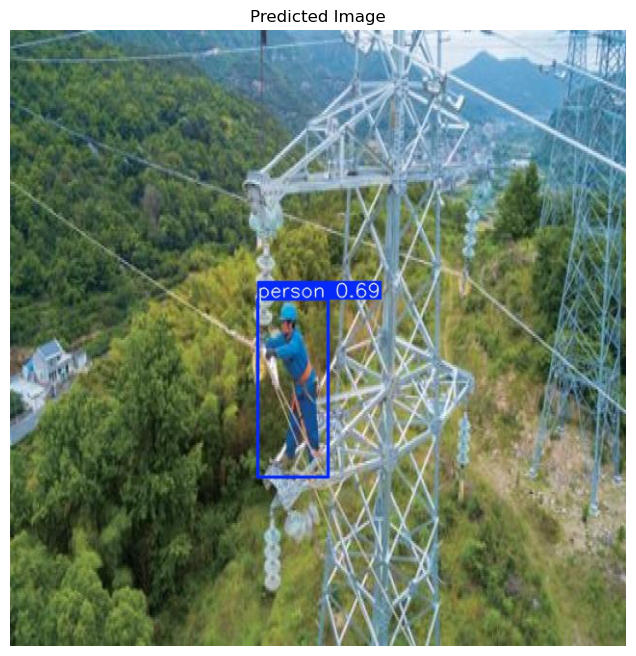

In [24]:
# === Display a Predicted Image from YOLOv8 Output ===
img_path = 'runs/detect/predict/005335_jpg.rf.f2a68acf4b0e45aeb6e930efcf695c28.jpg'

# Load and show the image using matplotlib
img = mpimg.imread(img_path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Predicted Image")
plt.show()